In [2]:
import pandas as pd
from os.path import abspath, join, dirname
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('C:/Users/enioh/Documents/Github/MMA-ML-Model/data/processed/PROCESSED_stats_plus_odds.csv')

In [3]:
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
df.drop(df.loc[df['result'] == 'D'].index, inplace=True) # Drop ties
df.head(5)

,date,fight_url,event_url,fighter_url,result,fighter,opponent,division,stance,dob,method,round,time,time_format,referee,height,reach,knockdowns,sub_attempts,reversals,control,takedowns_landed,takedowns_attempts,sig_strikes_landed,sig_strikes_attempts,total_strikes_landed,total_strikes_attempts,head_strikes_landed,head_strikes_attempts,body_strikes_landed,body_strikes_attempts,leg_strikes_landed,leg_strikes_attempts,distance_strikes_landed,distance_strikes_attempts,clinch_strikes_landed,clinch_strikes_attempts,ground_strikes_landed,ground_strikes_attempts,age,total_time,takedowns_absorbed,takedowns_defended,sig_strikes_absorbed,sig_strikes_defended,total_strikes_absorbed,total_strikes_defended,head_strikes_absorbed,head_strikes_defended,body_strikes_absorbed,body_strikes_defended,leg_strikes_absorbed,leg_strikes_defended,distance_strikes_absorbed,distance_strikes_defended,clinch_strikes_absorbed,clinch_strikes_defended,ground_strikes_absorbed,ground_strikes_defended,takedowns_accuracy,sig_strikes_accuracy,total_strikes_accuracy,head_strikes_accuracy,body_strikes_accuracy,leg_strikes_accuracy,distance_strikes_accuracy,clinch_strikes_accuracy,ground_strikes_accuracy,height_pM,reach_pM,knockdowns_pM,sub_attempts_pM,reversals_pM,control_pM,takedowns_landed_pM,takedowns_attempts_pM,sig_strikes_landed_pM,sig_strikes_attempts_pM,total_strikes_landed_pM,total_strikes_attempts_pM,head_strikes_landed_pM,head_strikes_attempts_pM,body_strikes_landed_pM,body_strikes_attempts_pM,leg_strikes_landed_pM,leg_strikes_attempts_pM,distance_strikes_landed_pM,distance_strikes_attempts_pM,clinch_strikes_landed_pM,clinch_strikes_attempts_pM,ground_strikes_landed_pM,ground_strikes_attempts_pM,age_pM,total_time_pM,takedowns_absorbed_pM,takedowns_defended_pM,sig_strikes_absorbed_pM,sig_strikes_defended_pM,total_strikes_absorbed_pM,total_strikes_defended_pM,head_strikes_absorbed_pM,head_strikes_defended_pM,body_strikes_absorbed_pM,body_strikes_defended_pM,leg_strikes_absorbed_pM,leg_strikes_defended_pM,distance_strikes_absorbed_pM,distance_strikes_defended_pM,clinch_strikes_absorbed_pM,clinch_strikes_defended_pM,ground_strikes_absorbed_pM,ground_strikes_defended_pM,takedowns_accuracy_pM,sig_strikes_accuracy_pM,total_strikes_accuracy_pM,head_strikes_accuracy_pM,body_strikes_accuracy_pM,leg_strikes_accuracy_pM,distance_strikes_accuracy_pM,clinch_strikes_accuracy_pM,ground_strikes_accuracy_pM,elo,height_differential,reach_differential,knockdowns_differential,sub_attempts_differential,reversals_differential,control_differential,takedowns_landed_differential,takedowns_attempts_differential,sig_strikes_landed_differential,sig_strikes_attempts_differential,total_strikes_landed_differential,total_strikes_attempts_differential,head_strikes_landed_differential,head_strikes_attempts_differential,body_strikes_landed_differential,body_strikes_attempts_differential,leg_strikes_landed_differential,leg_strikes_attempts_differential,distance_strikes_landed_differential,distance_strikes_attempts_differential,clinch_strikes_landed_differential,clinch_strikes_attempts_differential,ground_strikes_landed_differential,ground_strikes_attempts_differential,age_differential,total_time_differential,takedowns_absorbed_differential,takedowns_defended_differential,sig_strikes_absorbed_differential,sig_strikes_defended_differential,total_strikes_absorbed_differential,total_strikes_defended_differential,head_strikes_absorbed_differential,head_strikes_defended_differential,body_strikes_absorbed_differential,body_strikes_defended_differential,leg_strikes_absorbed_differential,leg_strikes_defended_differential,distance_strikes_absorbed_differential,distance_strikes_defended_differential,clinch_strikes_absorbed_differential,clinch_strikes_defended_differential,ground_strikes_absorbed_differential,ground_strikes_defended_differential,takedowns_accuracy_differential,sig_strikes_accuracy_differential,total_strikes_accuracy_differential,head_strikes_accuracy_differential,body_strikes_accuracy_di

# Feature Transofmration Pipeline

BASE_FEATURES from the RAW_fight_stats table  
- Takedowns
    - Landed
    - Attempts
- Significant Strikes
    - Landed 
    - Attempts
- Total Strikes
    - ...
- Head Strikes
- Body Strikes
- Leg Strikes
- Distance Strikes
- Clinch Strikes
- Ground Strikes

These BASE_FEATURES are then converted into both *absorbed* and *defended* according to the opponents values in the same bout 

- $ Stat_{Absorbed}^{F_A} = Stat_{Landed}^{F_B} $  
  
- $ Stat_{Defended}^{F_A} = Stat_{Attempts}^{F_B} - Stat_{Landed}^{F_B} $  

These are also converted into an *accuracy* measurement for a dimensionless unit 

- $ Stat_{Acc} = \frac{Stat_{Landed}}{Stat_{Attempts}} $

This obtains BASE_FEATURES and their extended features. I'm only including one base feature example to show the extension from now on
- Takedowns
    - Landed
    - Attempts
    - Absorbed
    - Defended
    - Accuracy 

Now using the total time of the bout converted into minutes, we can get a per miniute value of each stat due to the difference in bout lengths
- Takedowns
    - Landed
    - Landed Per Minute
    - Attempts
    - Attempts Per Minute
    - Absorbed
    - Abosrbed Per Minute
    - Defended
    - Defended Per Minute
    - Accuracy 
    - Accuracy Per Minute

We also add a custom ELO system using the fighters history for prior matches. Fighters are granted more ELO on finishes and more on earlier rounds 

- ELO (added as base feature)

We can calculate the 'differential' between two fighters, or in other words the relative weight one fighter has over their opponent

- $ Stat_{diff}^{F_A} = \frac{Stat^{F_A}}{Stat^{F_A} + Stat^{F_B}} $ 

Since these stats are all post-fight, we can't use them for predictions, we need prior statistics from the fighters previous fights and perform transformations. A fight at t=0 uses t-1, t-2, t-3, ... and so on. For windowed functions, only use t-1, t-2, t-3 depending on window size.

- Takedowns
    - Landed
        - Precomp Landed Prior
        - Precomp Landed Avg
        - Precomp Landed Window Avg
        - Precomp Landed EWM Avg
        - Precomp Landed Variance
        - Precomp Landed Window Variance
        - Precomp Landed Peak
        - Precomp Landed Low
        - Precomp Landed Delta

Finally do the difference between these stats and the opponents to get the feature inputs for the model

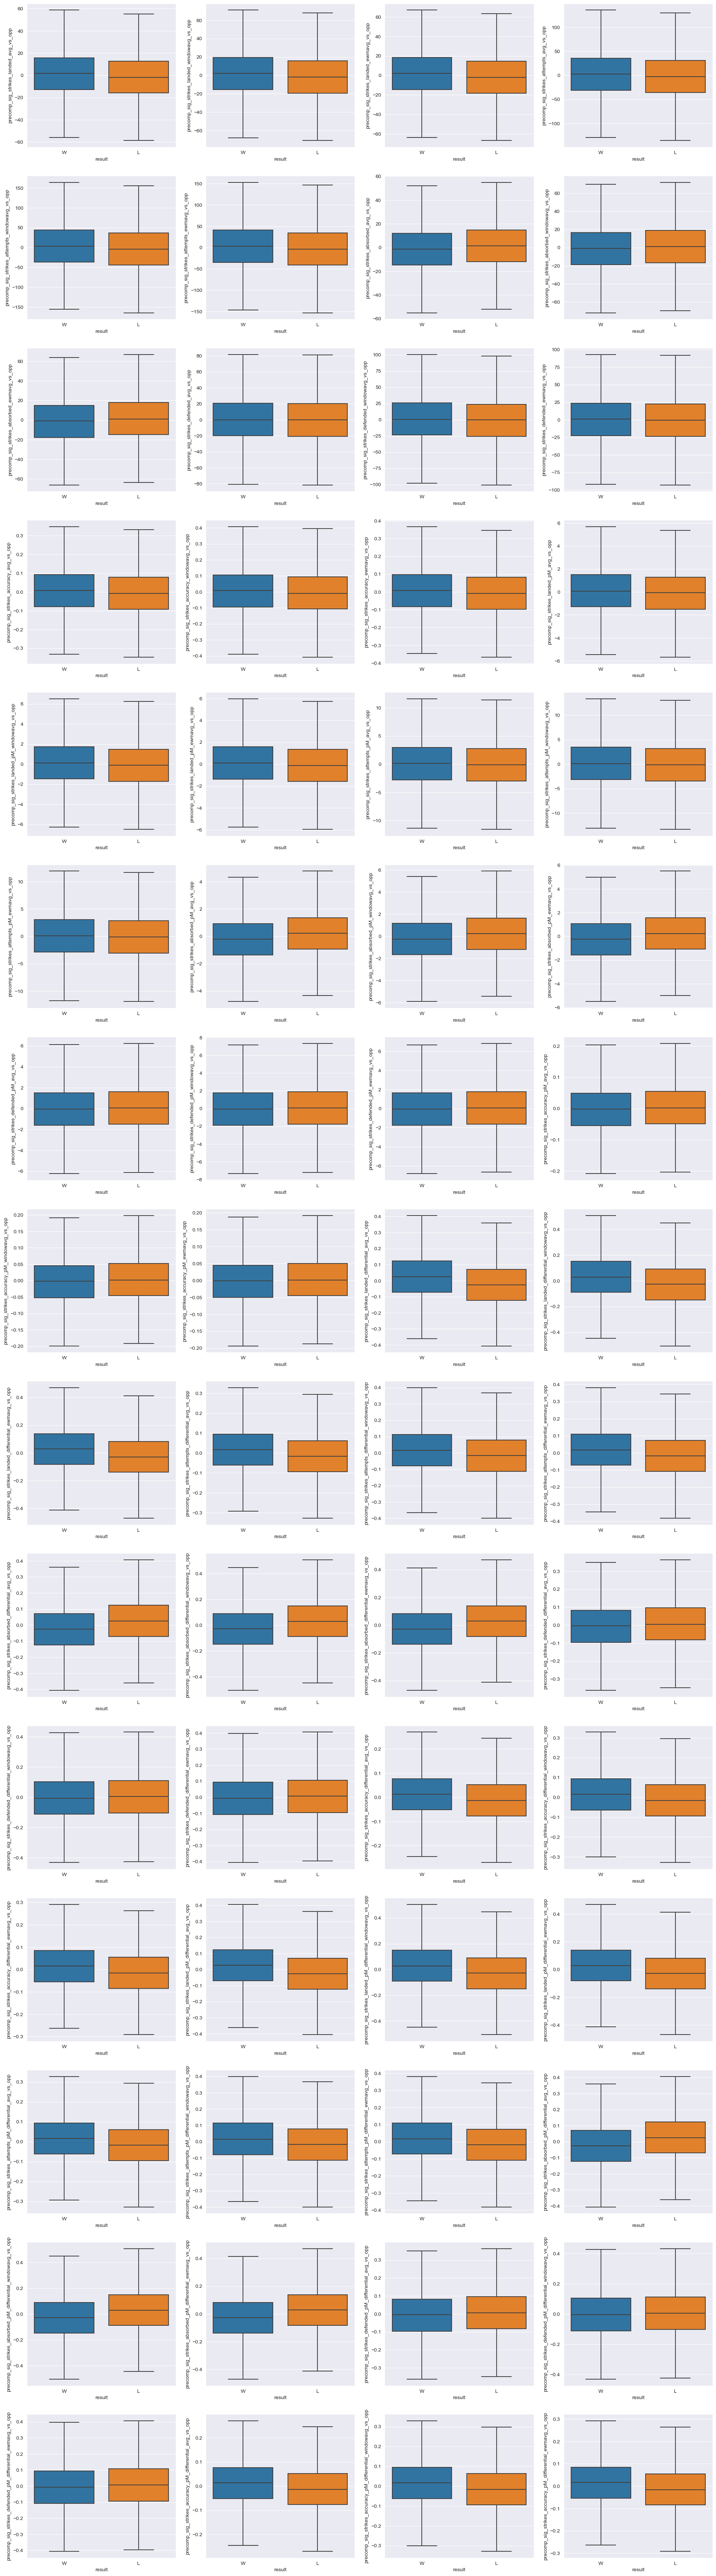

In [4]:
strike_type = 'sig_strikes'
extension_function = 'avg'
cols = df.loc[:,df.columns.str.contains('precomp_' + strike_type + '(?:[a-zA-Z_]+)' + extension_function + '_vs_opp', regex=True)].columns

size0 = len(cols)
size1 = int(np.ceil(size0 / 4))

scale = 6
size = (4*scale , size1*scale)

fig, ax = plt.subplots(size1, 4, figsize=size)
for col, ax in zip(cols, ax.reshape(-1)):
    sns.boxplot(data=df, x='result', y=col, ax=ax, showfliers=False)

Some feature combinations that may be relevant that might not be formed during model training and their reasoning.

Fighter 'Ground Activity' Stat
- How active a fighter is when dealing damage when he is on the ground.

- $ Stat = \frac{Ground \ Strks \ Landed}{Control \ Time} $ 



c:\Users\enioh\miniconda3\envs\MMA-ML-Model\lib\site-packages\seaborn\distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
c:\Users\enioh\miniconda3\envs\MMA-ML-Model\lib\site-packages\seaborn\distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
c:\Users\enioh\miniconda3\envs\MMA-ML-Model\lib\site-packages\seaborn\distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
c:\Users\enioh\miniconda3\envs\MMA-ML-Model\lib\site-packages\seaborn\distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
c:\Users\enioh\miniconda3\envs\MMA-ML-Model\lib\site-packages\seaborn\distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
c:\Users\enioh\miniconda3\envs\MMA-ML-Model\lib\site-packages\seaborn\distributions.py:1185: UserWar

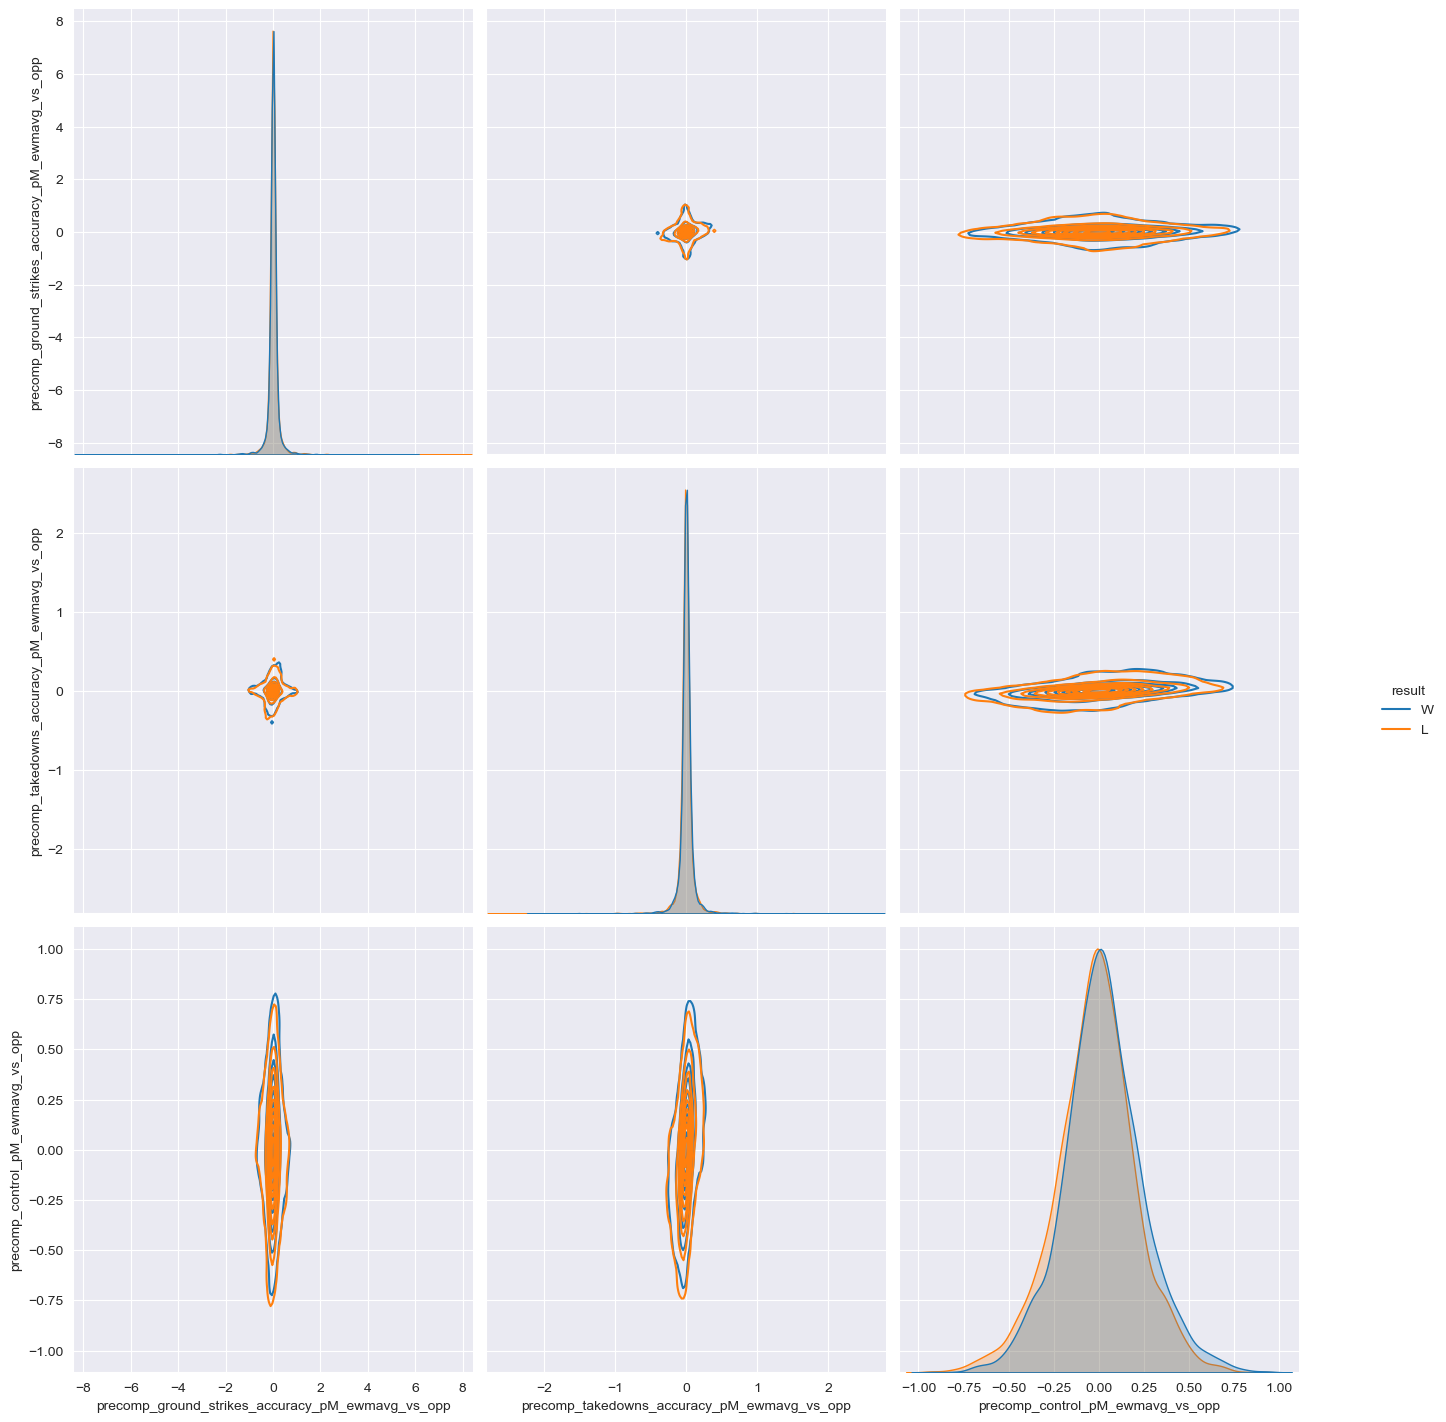

In [21]:
related_stats = ['precomp_ground_strikes_accuracy_pM_ewmavg_vs_opp', 
                 'precomp_takedowns_accuracy_pM_ewmavg_vs_opp',
                 'precomp_control_pM_ewmavg_vs_opp',
                 'result' # Hue
                ]

jit_x = np.random.random(df[related_stats].shape[0]) - 0.5

g=sns.pairplot(df[related_stats], hue='result', kind='kde')
g.fig.set_size_inches(15,15)